In [1]:
%matplotlib inline
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import pandas as pd
from sctools import integrate, plot, io

Global seed set to 0


## Integration of T-cell subsets for identification of regulatory T-cells
Here we extract the identified T-cell subset from the original dataset and integrate it anew to avoid incorporating artifacts introduced into the embedding by other celltypes we are not interested in.

In [3]:
# load data
prefixes = ['tissue.scps', 'tissue.ad', 'tissue.uc', 'pbmc.scps']
adatas = {}
for key in prefixes:
    adata = io.initialize_from_raw(f'../data/{key}.integrated.clustered.h5ad')
    adatas[key] = adata[adata.obs.coarse_cell_types == 'Tcell'].copy()
    del adata
    
adatas

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


{'tissue.scps': AnnData object with n_obs × n_vars = 62462 × 20912
     obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types',
 'tissue.ad': AnnData object with n_obs × n_vars = 61787 × 21750
     obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.25', 'coarse_cell_types',
 'tissue.uc': AnnData object with n_obs × n_vars = 46867 × 18436
     obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.4', 'coarse_cell_types',
 'pbmc.scps': AnnData object with n_obs × n_vars = 18557 × 15998
     

In [4]:
# visualize raw data
for k, adata in adatas.items():
    print(k)
    plot.integrate.raw_data_umap(
        adata,
        ['status', 'sample_id', 'FOXP3'],
        size = 10,
        vmax = 0.5,
        savefile = f'../plots/{k}.raw.umap.png'
    )

tissue.scps


/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/st

TypeError: unsupported operand type(s) for ** or pow(): 'bool' and 'dict'

In [ ]:
# integrate tcells
integration_params = {
    f'tcells.{k}': {'kwargs': dict()} for k in adata.keys()
}

integration_results = {}
for key, adata in adatas.items():
    key = f'tcells.{key}'
    params = integration_params[key]
        
    print(key)
    integration_results[key] = integrate.integrate_data_scvi(
        adata.copy(),
        'sample_id',
        train_size = 1,
        **params['kwargs']
    )

    integration_results[key]['data'].write(
        f'../data/{key}.integrated.h5ad'
    )

    integration_results[key]['model'].save(
        f'../data/{key}.integration.scvi.model',
        overwrite = True
    )

In [10]:
# restore results if kernel breaks or gets shut down
integration_results = {}
for key in ['tissue.scps', 'tissue.ad', 'tissue.uc', 'pbmc.scps']:
    print(key)
    data = sc.read_h5ad(
        f'../data/tcells.{key}.integrated.h5ad'
    )
    integration_results[key] = {
        'data': data,
        'model': scvi.model.SCVI.load(
            f'../data/tcells.{key}.integration.scvi.model', 
            adata = data
        )
    }

tissue.scps
tissue.ad


/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/site-packages/scvi/data/_utils.py:156: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


tissue.uc
pbmc.scps


In [9]:
fig, axs = plot.integrate.plot_integration_results(
    integration_results,
    ['sample_id', 'status', 'FOXP3', 'CD3D'],
    [
        dict(size = 20, vmax = None),
        dict(size = 20, vmax = None),
        dict(size = 20, vmax = 1),
        dict(size = 20, vmax = 5)
    ],
    data_key = 'data'
)

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModification

## Treg annotation

In [3]:
fig, axs = plot.integrate.plot_leiden_clusterings(
    integration_results,
    [0.5, 0.75, 1, 1.25],
    data_key = 'data',
    legend_loc = 'right margin'
)

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModification

In [6]:
resolutions = {
    'tcells.tissue.scps': 0.4,
    'tcells.tissue.uc': 0.4,
    'tcells.tissue.ad': 0.25,
    'tcells.pbmc.scps': 0.5
}
for k, resolution in resolutions.items():
    d = integration_results[k]
    sc.tl.leiden(
        d['data'], 
        key_added = f'leiden_scvi_{resolution}',
        resolution = resolution
    )

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


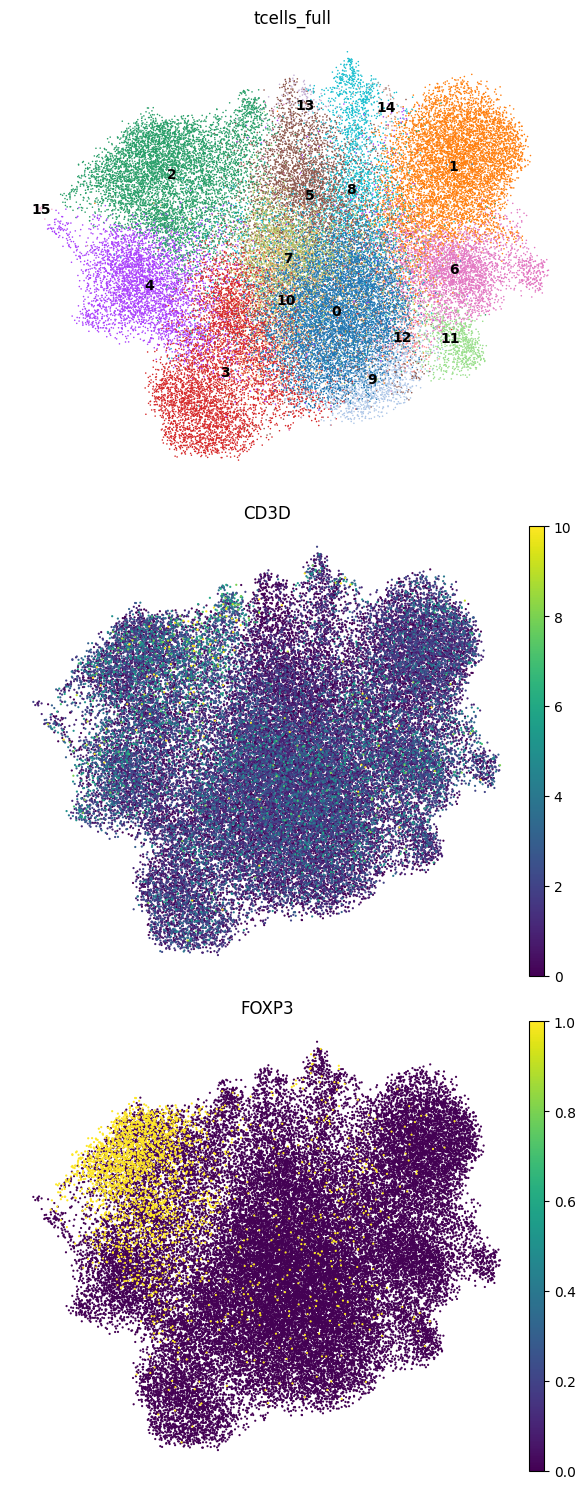

In [7]:
cluster_keys = {k: f'leiden_scvi_{r}' for k, r in resolutions.items()}
fig, axs = plot.integrate.plot_clustering_and_expression(
    integration_results,
    cluster_keys,
    ['CD3D', 'FOXP3'],
    [
        dict(size = 10, vmax = None, legend_loc = 'on data'),
        dict(size = 10, vmax = 10),
        dict(size = 10, vmax = 1)
    ],
    data_key = 'data'
)

In [8]:
treg_clusters = {
    'tcells.tissue.scps': '2,4,6',
    'tcells.tissue.uc': '2,4,6',
    'tcells.tissue.ad': '2,4,6',
    'tcells.pbmc.scps': '2,4,6'
}

treg_clusters = {
    k: [c for c in cs.split(',')] for k, cs in tcell_clusters.items()
}

tcells_full coarse_cell_types
Treg      6272
other    40595
Name: sample_id, dtype: int64


/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


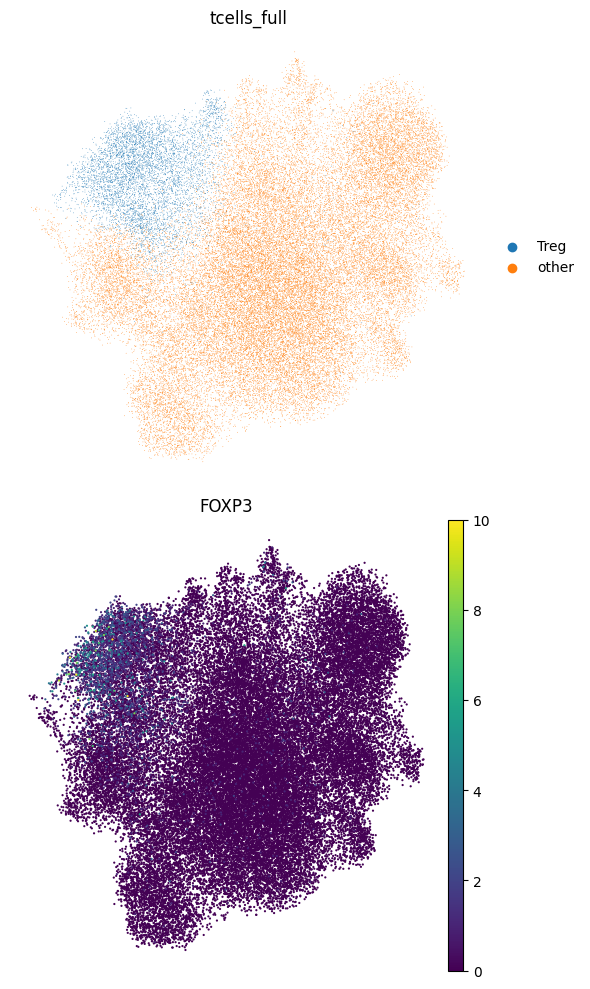

In [11]:
for k, d in integration_results.items():
    clustering = cluster_keys[k]
    cluster_to_treg = treg_clusters[k]
    d['data'].obs['t_cell_types'] = d['data'].obs[clustering].apply(
        lambda x: 'Treg' if x in cluster_to_treg[k] else 'other'
    )
    print(k, d['data'].obs.groupby('t_cell_types').count().iloc[:, 0])
    
fig, axs = plot.integrate.plot_clustering_and_expression(
    integration_results,
    {k: 't_cell_types' for k in integration_results.keys()},
    ['CD3D'],
    [
        dict(size = 10, vmax = None),
        dict(size = 10, vmax = 10)
    ],
    data_key = 'data'
)

In [12]:
for k, d in integration_results.items():
    d['data'].write(
        f'../data/{k}.integrated.clustered.h5ad'
    )

In [ ]:
for k, d in integration_results.items():
    adata = d['data']
    prefix = key.replace('tcells', 'tregs')
    io.write_sc_data(
        adata[adata.obs.t_cell_types == 'Treg', :],
        '../diffexp/{prefix}',
        obs_columns = ['sample_id', 'status']
    )